# Path Planning for a Simple Car

Keywords: optimal control, path planning, ipopt usage, rescaling time

## Imports

The following cell checks if pyomo is installed amd, if not, executes a 

    !pip install -q pyomo
   
command to install pyomo.  The following statement attempts to install the ipopt solver. This code is not bullet proof. If installation errors occur, try to install manually before proceeding further.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))

## Mathematical model

![Simple Car](https://github.com/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/figures/SimpleCar.png?raw=1)

The following equations describe a simple model of a car at low speeds

$$
\begin{align}
\frac{dx}{dt} & = v \cos(\theta) \\
\frac{dy}{dt} & = v \sin(\theta) \\
\frac{d\theta}{dt} & = \frac{v}{L}\tan(\phi) \\
\frac{dv}{dt} & = a_v \\
\end{align}
$$

where $x$ and $y$ denote the position of the center of the rear axle, $v$ is velocity, $\theta$ is the angle of the car axis to the horizontal, and $\phi$ is the angle of the front steering wheels relative to the car axis. The car length $L$ is the distance between the front and rear axles. The car responds to acceleration input $a_v$ and and steering input $\phi$.

The lateral acceleration (or lateral "g" force) on the car is $v^2/R$ where $R = L/\sin(\phi)$ is the radius of curvature. Denoting lateral acceleration as $a_r$, 

$$
\begin{align}
a_r & = \frac{v^2 \sin(\phi)}{L} \\
\end{align}
$$

The path planning problem is to find values $a_v(t)$ and $\phi(t)$ on an interval $0 \leq t \leq t_f$ which steer the car from an initial condition $\left[x(0), y(0), \theta(0), u(0)\right]$ to a specified final condition $\left[x(t_f), y(t_f), \theta(t_f), u(t_f)\right]$. The desired control inputs minimizes an objective function:

$$
\begin{align}
J  = \min \int_0^{t_f} \left( a_v(t)^2  + \gamma a_r(t)^2 \right)\,dt
\end{align}
$$

subject to the following limits $a_v$, $\phi$, and $v$.

| variable | bound |
| :---: | :---: |
| $|a_r|$ | 2.8 $m/s$ |
| $|a_v|$ | 2.8 $m/s$ |
| $|\phi|$ | 0.7 $rad$ |
| $v$ | 30 $m/s$ |
| $-v$ | 4 $m/s$ |

The next cells implement the model using a fixed estimate for $t_f$, the time required to complete the desired maneuver.

## Pyomo model

In [2]:
from pyomo.environ import *
from pyomo.dae import *

# parameters
ar_max = 2.8
av_max = 2.8
phi_max = 0.7
v_max  = 30
v_min = -4

# time and length scales
L = 5
tf = 40

# create a model object
m = ConcreteModel()

# define the independent variable
m.t = ContinuousSet(bounds=(0, tf))

# define control inputs
m.av = Var(m.t)
m.phi = Var(m.t, bounds=(-phi_max, phi_max))

# define the dependent variables
m.x = Var(m.t)
m.y = Var(m.t)
m.a = Var(m.t)
m.v = Var(m.t)

# define derivatives
m.x_dot = DerivativeVar(m.x)
m.y_dot = DerivativeVar(m.y)
m.a_dot = DerivativeVar(m.a)
m.v_dot = DerivativeVar(m.v)

# define the differential equation as constrainta
m.ode_x = Constraint(m.t, rule=lambda m, t: m.x_dot[t] == m.v[t]*cos(m.a[t]))
m.ode_y = Constraint(m.t, rule=lambda m, t: m.y_dot[t] == m.v[t]*sin(m.a[t]))
m.ode_a = Constraint(m.t, rule=lambda m, t: m.a_dot[t] == m.v[t]*tan(m.phi[t])/L)
m.ode_v = Constraint(m.t, rule=lambda m, t: m.v_dot[t] == m.av[t])

# path constraints
m.path_x1 = Constraint(m.t, rule=lambda m, t: m.x[t] >= 0)
m.path_y1 = Constraint(m.t, rule=lambda m, t: m.y[t] >= 0)
m.path_v1 = Constraint(m.t, rule=lambda m, t: m.v[t] <= v_max)
m.path_v2 = Constraint(m.t, rule=lambda m, t: m.v[t] >= v_min)
m.path_a1 = Constraint(m.t, rule=lambda m, t: m.av[t] <= av_max)
m.path_a2 = Constraint(m.t, rule=lambda m, t: m.av[t] >= -av_max)
m.path_a3 = Constraint(m.t, rule=lambda m, t: m.v[t]**2*sin(m.phi[t])/L <= ar_max)
m.path_a4 = Constraint(m.t, rule=lambda m, t: m.v[t]**2*sin(m.phi[t])/L >= -ar_max)

# initial conditions
m.pc = ConstraintList()
m.pc.add(m.x[0]==0)
m.pc.add(m.y[0]==0)
m.pc.add(m.a[0]==0)
m.pc.add(m.v[0]==0)

# final conditions
m.pc.add(m.x[tf]==0)
m.pc.add(m.y[tf]==4*L)
m.pc.add(m.a[tf]==0)
m.pc.add(m.v[tf]==0)

# final conditions on the control inputs
m.pc.add(m.av[tf]==0)
m.pc.add(m.phi[tf]==0)

# define the optimization objective
m.integral = Integral(m.t, wrt=m.t, rule=lambda m, t: m.av[t]**2 + (m.v[t]**2*sin(m.phi[t])/L)**2)
m.obj = Objective(expr=m.integral)

# transform and solve
TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=30)
SolverFactory('ipopt').solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 502
  Number of variables: 310
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.13.4\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 2.6352779865264893
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


## Accessing solution data

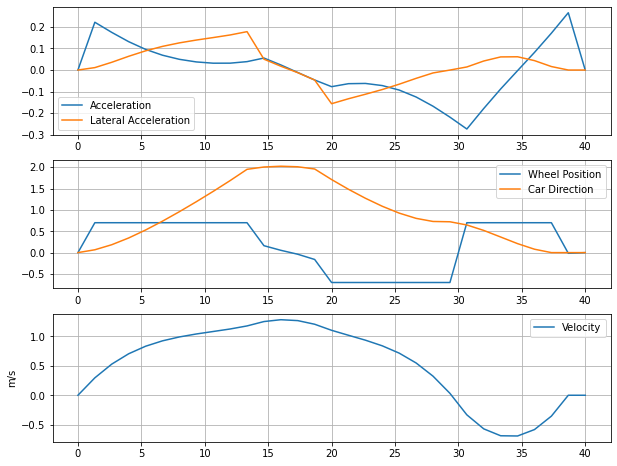

In [3]:
# access the results
t = np.array([t for t in m.t])

av = np.array([m.av[t]() for t in m.t])
ar = np.array([(m.v[t]()**2 * np.sin(m.phi[t]()))/L for t in m.t])
phi = np.array([m.phi[t]() for t in m.t])

x = np.array([m.x[t]() for t in m.t])
y = np.array([m.y[t]() for t in m.t])
a = np.array([m.a[t]() for t in m.t])
v = np.array([m.v[t]() for t in m.t])

def plot_results(t, x, y, a, v, av, phi):
    fig, ax = plt.subplots(3,1, figsize=(10,8))

    ax[0].plot(t, av, t, v**2*np.sin(phi)/L)
    ax[0].legend(['Acceleration','Lateral Acceleration'])

    ax[1].plot(t, phi, t, a)
    ax[1].legend(['Wheel Position','Car Direction'])

    ax[2].plot(t, v)
    ax[2].legend(['Velocity'])
    ax[2].set_ylabel('m/s')
    for axes in ax:
        axes.grid(True)
        
plot_results(t, x, y, a, v, av, phi)

## Visualizing the car path

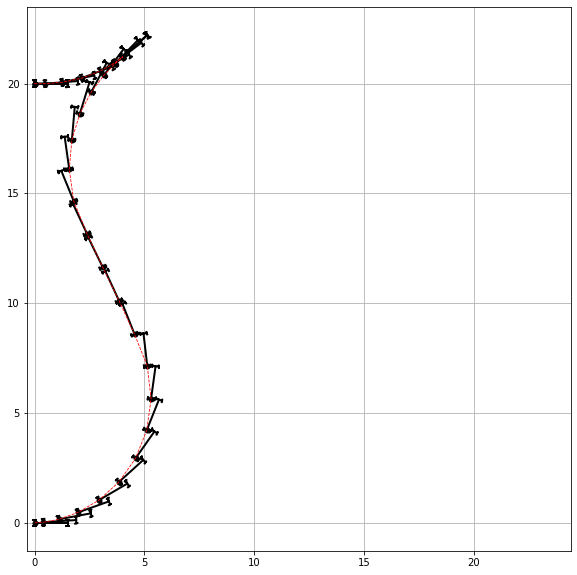

In [4]:
scl=0.3

def draw_car(x=0, y=0, a=0, phi=0):
    R = np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]])
    car = np.array([[0.2, 0.5], [-0.2, 0.5], [0, 0.5], [0, -0.5],
                    [0.2, -0.5], [-0.2, -0.5], [0, -0.5], [0, 0], [L, 0], [L, 0.5],
                    [L + 0.2*np.cos(phi), 0.5 + 0.2*np.sin(phi)],
                    [L - 0.2*np.cos(phi), 0.5 - 0.2*np.sin(phi)], [L, 0.5],[L, -0.5],
                    [L + 0.2*np.cos(phi), -0.5 + 0.2*np.sin(phi)],
                    [L - 0.2*np.cos(phi), -0.5 - 0.2*np.sin(phi)]])
    carz = scl*R.dot(car.T)
    plt.plot(x + carz[0], y + carz[1], 'k', lw=2)
    plt.plot(x, y, 'k.', ms=10)
    
plt.figure(figsize=(10,10))
for xs,ys,ts,ps in zip(x, y, a, phi):   
    draw_car(xs, ys, ts, scl*ps)
plt.plot(x, y, 'r--', lw=0.8)
plt.axis('square')
plt.grid(True)

## Rescaling to incorporate time into the optimization model

While out initial formulation of the path planning problem leads to a solution, one unsatisfactory aspect of the formulation is the need to estimate the time necessary to complete the maneuver. Here we rescale the problem in such a way that the time horizon becomes part of the optimization calculation.

The following equations describe a simple model of a car

$$
\begin{align}
\frac{dx}{dt'} & = t_f v \cos(\theta) \\
\frac{dy}{dt'} & = t_f v \sin(\theta) \\
\frac{d\theta}{dt'} & = \frac{t_f }{L}\tan(\phi) \\
\frac{dv}{dt'} & = t_f a_v \\
\end{align}
$$

subject to bounds on the manipulable variables.

$$
\begin{align}
| a_v | & \leq a^{max}_v \\
|\frac{v^2\sin(\phi)}{L}| & \leq a^{max}_r \\
|\phi | & \leq \phi^{max} \\
| v | & \leq v^{max} \\
\end{align}
$$

The objective function 

$$
\begin{align}
J  = t_f \min \int_0^{1} \left( \phi(t)^2 + \alpha a(t)^2 + \beta v(t)^2\right)\,dt'
\end{align}
$$

Introduce the natural scales

$$
\begin{align}
x' & = \frac{x}{L} \\
y' & = \frac{y}{L} \\
v' & = \frac{t_f}{L} v \\
a'_v & = \frac{t_f^2}{L} a_v\\
\end{align}
$$

Resulting

$$
\begin{align}
\frac{dx'}{dt'} & = v' \cos(\theta) \\
\frac{dy'}{dt'} & = v' \sin(\theta) \\
\frac{d\theta}{dt'} & = v' \tan(\phi) \\
\frac{dv'}{dt'} & = a'_v \\
\end{align}
$$

The bounds become

$$
\begin{align}
|a'_v| & \leq \frac{t_f^2}{L}a^{max}_v \\
|v'^2\sin(\phi)| & \leq \frac{t_f^2}{L}a^{max}_r \\
|\phi | & \leq \phi^{max} \\
| v' | & \leq \frac{t_f}{L}v^{max} \\
\end{align}
$$

In the rescaled variables, the objective function becomes

$$
\begin{align}
J  =  \min  \left[ t_f + \frac{L^2}{t_f^3} \int_0^1  \left(\gamma_v a_v^2  + \gamma_r v^4 \sin^2(\phi) \right)\,dt\right]
\end{align}
$$

where an additional term $t_f$ has been included to incorporate a tradeoff between applied acceleration and corning forces and the time required to complete the maneuver.


In [5]:
# parameters
ar_max = 2.8
av_max = 2.8
phi_max = 0.7
v_max  = 30
v_min = -4

# time and length scales
L = 5

# create a model object
m = ConcreteModel()

# define the independent variable
m.tf = Var(domain=NonNegativeReals)
m.t = ContinuousSet(bounds=(0, 1))

# define control inputs
m.av = Var(m.t)
m.phi = Var(m.t, bounds=(-phi_max, phi_max))

# define the dependent variables
m.x = Var(m.t)
m.y = Var(m.t)
m.a = Var(m.t)
m.v = Var(m.t)

# define derivatives
m.x_dot = DerivativeVar(m.x)
m.y_dot = DerivativeVar(m.y)
m.a_dot = DerivativeVar(m.a)
m.v_dot = DerivativeVar(m.v)

# define the differential equation as constrainta
m.ode_x = Constraint(m.t, rule=lambda m, t: m.x_dot[t] == m.v[t]*cos(m.a[t]))
m.ode_y = Constraint(m.t, rule=lambda m, t: m.y_dot[t] == m.v[t]*sin(m.a[t]))
m.ode_a = Constraint(m.t, rule=lambda m, t: m.a_dot[t] == m.v[t]*tan(m.phi[t])/L)
m.ode_v = Constraint(m.t, rule=lambda m, t: m.v_dot[t] == m.av[t])

# path constraints
m.path_x1 = Constraint(m.t, rule=lambda m, t: m.x[t] >= 0)
m.path_y1 = Constraint(m.t, rule=lambda m, t: m.y[t] >= 0)
m.path_v1 = Constraint(m.t, rule=lambda m, t: m.v[t] <= m.tf*v_max/L)
m.path_v2 = Constraint(m.t, rule=lambda m, t: m.v[t] >= m.tf*v_min/L)
m.path_a1 = Constraint(m.t, rule=lambda m, t: m.av[t] <= m.tf**2*av_max/L)
m.path_a2 = Constraint(m.t, rule=lambda m, t: m.av[t] >= -m.tf**2*av_max/L)
m.path_a3 = Constraint(m.t, rule=lambda m, t: m.v[t]**2*sin(m.phi[t]) <= m.tf**2*ar_max/L)
m.path_a4 = Constraint(m.t, rule=lambda m, t: m.v[t]**2*sin(m.phi[t]) >= -m.tf**2*ar_max/L)

# initial conditions
m.pc = ConstraintList()
m.pc.add(m.x[0]==0)
m.pc.add(m.y[0]==0)
m.pc.add(m.a[0]==0)
m.pc.add(m.v[0]==0)

# final conditions
m.pc.add(m.x[1]==0)
m.pc.add(m.y[1]==4)
m.pc.add(m.a[1]==0)
m.pc.add(m.v[1]==0)

# final conditions on the control inputs
m.pc.add(m.av[1]==0)
m.pc.add(m.phi[1]==0)

# define the optimization objective
m.integral = Integral(m.t, wrt=m.t, rule=lambda m, t: m.av[t]**2 + (m.v[t]**2*sin(m.phi[t]))**2)
m.obj = Objective(expr= m.tf + L**2*m.integral/m.tf**3)

# transform and solve
TransformationFactory('dae.finite_difference').apply_to(m, wrt=m.t, nfe=30)
SolverFactory('ipopt').solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 502
  Number of variables: 311
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.13.4\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 1.447754144668579
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


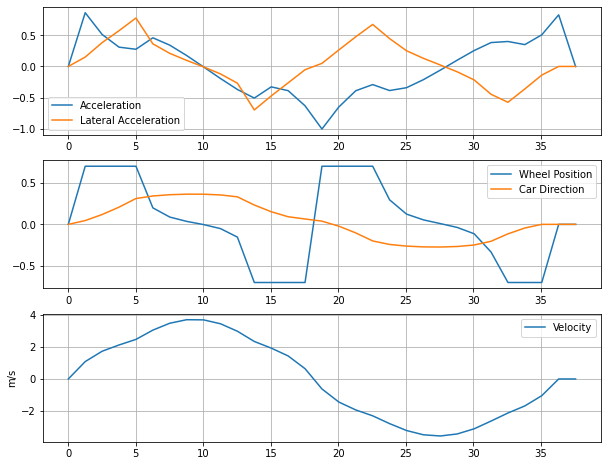

In [6]:
# access the results
t = np.array([t*m.tf() for t in m.t])

av = np.array([m.av[t]()*L/(m.tf()**2) for t in m.t])
phi = np.array([m.phi[t]() for t in m.t])

x = np.array([m.x[t]()*L for t in m.t])
y = np.array([m.y[t]()*L for t in m.t])
a = np.array([m.a[t]() for t in m.t])
v = np.array([m.v[t]()*L/m.tf() for t in m.t])

ar = v**2 * np.sin(phi)/L
        
plot_results(t, x, y, a, v, av, phi)

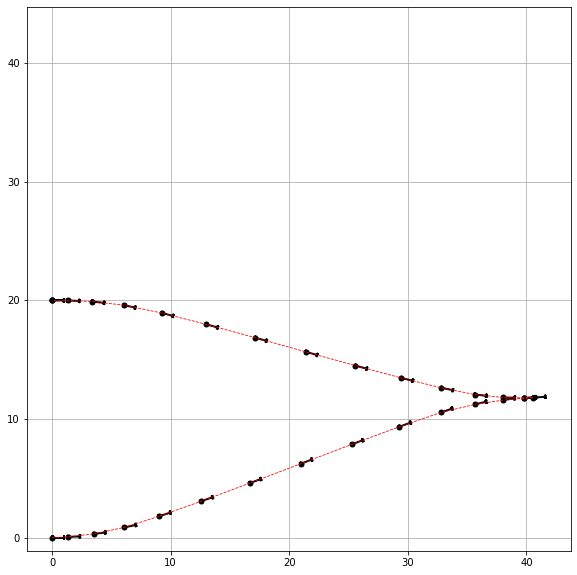

In [7]:
scl=0.2

plt.figure(figsize=(10,10))
for xs,ys,ts,ps in zip(x, y, a, phi):   
    draw_car(xs, ys, ts, scl*ps)
plt.plot(x, y, 'r--', lw=0.8)
plt.axis('square')
plt.grid(True)

In [8]:
print(m.tf())

37.569148444099255
